# Cox proportional hazard model

앞서 나온 kaplan과 log rank는 event의 발생 여부만을 고려하여 분석을 수행하지만, cox 분석은 생존에 영향을 미치는 여러가지의 risk factor 위험요소에 대한 분석을 시행한다

#### 가정)
    1. sample간에 생존 시간은 독립적이다.
    2. 예측 변수와 hazard 사이에 곱셈이라는 관계가 존재한다.
    3. 시간이 지남에 따라 일정한 위험비율을 가지고 있다.


---
> Q. 왜 비례라는 단어를 사용할까?  
 A: 단위가 하나 증가할수록 계수의 지수배만큼 증가하는 효과가 존재한다.

$$
\begin{aligned}
\lambda(t \mid x + 1) &= \lambda_0(t)\exp(\beta_1(x + 1)) \\
&= \lambda_0(t)\exp(\beta_1 x + \beta_1) \\
&= \left[\lambda_0(t)\exp(\beta_1 x)\right] \exp(\beta_1) \\
&= \lambda(t \mid x) \exp(\beta_1)
\end{aligned}
$$

***Hazard : Baseline hazard + Partial hazard***

# 분석

In [5]:
import pandas as pd

data = pd.read_csv("Kaplan-Meier_Example_Dataset.csv")
data.head()

,time,event,group,gender
0,4.7,1,ESRD,female
1,30.1,1,cardiac,male
2,13.2,1,respiratory,female
3,9.1,1,respiratory,male
4,1.7,0,ESRD,female


In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['group'] = encoder.fit_transform(data['group'])
data['gender'] = encoder.fit_transform(data['gender'])

In [9]:
from lifelines import CoxPHFitter

coxph = CoxPHFitter()
coxph.fit(data, duration_col = 'time', event_col = 'event')

data_new = data.loc[data['event'] == 0]  # censored가 된 환자만을 추리는 subset
data_new_obs = data_new['time']  # 환자들의 실제 관측된 시간 (censoring time)
predictions = coxph.predict_survival_function(data_new, conditional_after = data_new_obs)
pd.DataFrame(predictions).head(11).iloc[:, :5]


,4,7,12,13,15
0.1,0.992602,0.993344,0.996197,0.998044,0.992211
0.2,0.985260,0.986732,0.992408,0.996091,0.984483
0.3,0.956125,0.980164,0.988633,0.994142,0.984483
0.5,0.941289,0.967160,0.981127,0.990256,0.981768
0.6,0.941289,0.960722,0.977395,0.988319,0.979059
0.7,0.941289,0.954328,0.973678,0.982445,0.976359
0.8,0.938693,0.947976,0.969974,0.976605,0.973665
0.9,0.936103,0.941666,0.966285,0.964854,0.970980
1.0,0.933521,0.935398,0.962610,0.953069,0.968301
1.1,0.930946,0.929172,0.958949,0.941244,0.960193


#### 해석)
- 5명의 객체인 4, 7, 12, 13, 15에 대해서 시간 t 에대한 생존확률을 추정하는 것임
- 왜 conditional_after을 하는 걸까?
    - 예를 들어 한 환자에게서 3일동안 생존하고 그이후에는 censored 되었다.
    - 관심있는 것은 **"3일동안 생존한 조건 하에, 앞으로 생존할 확률?"**이다.
    - conditional_after를 설정하게 되면, P(T > t | T > 3)처럼 조건부 생존 확률을 예측하게 된다

<AxesSubplot:>

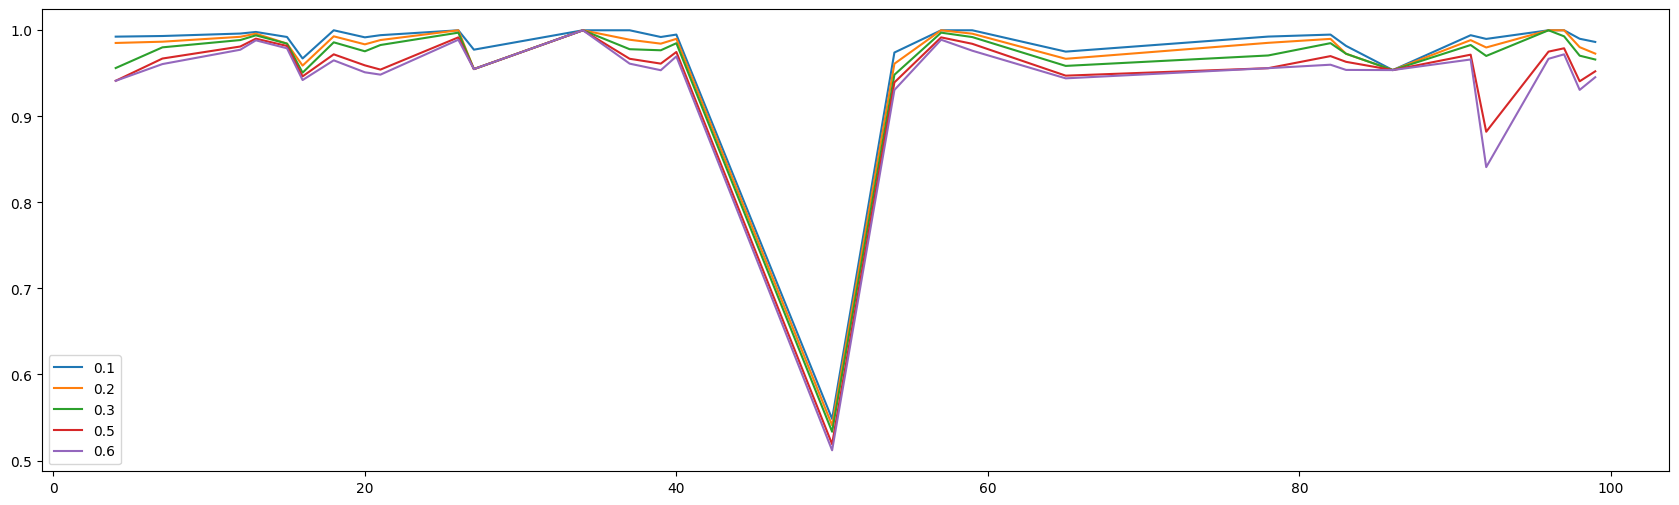

In [12]:
pd.DataFrame(predictions).head().T.plot(figsize=(21,6))

# 결과 시각화

<Figure size 800x500 with 0 Axes>

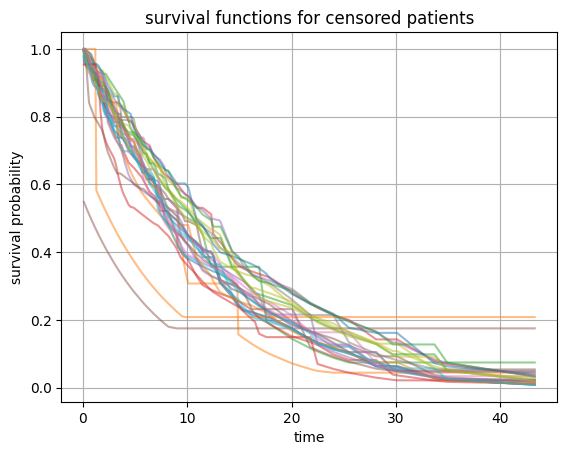

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 5))
predictions.plot(legend = False, alpha = 0.5)
plt.title('survival functions for censored patients')
plt.xlabel('time')
plt.ylabel('survival probability')
plt.grid(True)
plt.show()

In [27]:
# Group 별로 mean, std 로 표현해주기

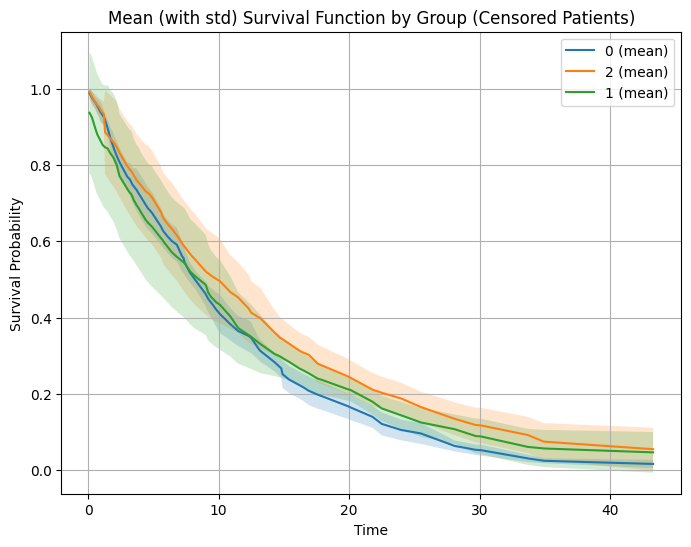

In [33]:
groups = data_new['group'].reset_index(drop = True)

group_means = {}
group_stds = {}

# 그룹별로 평균과 표준편차 계산
for group_name in groups.unique():
    group_mask = groups == group_name
    group_preds = predictions.loc[:, group_mask.values]  # 시간 x 환자 수
    group_means[group_name] = group_preds.mean(axis=1)
    group_stds[group_name] = group_preds.std(axis=1)


plt.figure(figsize = (8, 6))

for group_name in group_means:
    mean_series = group_means[group_name]
    std_series = group_stds[group_name]

    x = mean_series.index.to_numpy()
    y = mean_series.to_numpy()
    y_lower = (mean_series - std_series).to_numpy()
    y_upper = (mean_series + std_series).to_numpy()

    plt.plot(x, y, label=f'{group_name} (mean)')
    plt.fill_between(x, y_lower, y_upper, alpha=0.2)

plt.title("Mean (with std) Survival Function by Group (Censored Patients)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

# 특정 시점의 생존 확률은?

In [18]:
print(predictions.index)  # 앞부분 10개 시간 확인

Index([ 0.1,  0.2,  0.3,  0.5,  0.6,  0.7,  0.8,  0.9,  1.0,  1.1,  1.2,  1.3,
        1.5,  1.7,  1.9,  2.0,  2.2,  2.4,  3.0,  3.2,  3.3,  3.4,  3.5,  3.6,
        3.7,  3.9,  4.0,  4.4,  4.6,  4.7,  4.9,  5.6,  5.7,  5.8,  6.1,  6.4,
        6.8,  7.2,  7.3,  7.4,  7.8,  7.9,  8.2,  9.0,  9.1,  9.2,  9.4,  9.5,
        9.8, 10.1, 10.9, 11.5, 12.3, 12.5, 13.1, 13.2, 14.3, 14.7, 14.8, 14.9,
       15.4, 16.2, 16.5, 16.9, 17.6, 17.9, 19.9, 20.1, 21.8, 22.5, 24.0, 25.5,
       28.1, 29.7, 30.1, 33.7, 34.9, 35.0, 43.3],
      dtype='float64')


In [19]:
# 예: t = 5일에서 모든 환자의 생존 확률을 추출
survival_at_5 = predictions.loc[5.6]  # t=5.6일에 해당하는 row

print("각 환자의 5.6일 생존 확률:")
print(survival_at_5)

각 환자의 5.6일 생존 확률:
4     0.653075
7     0.577771
12    0.709694
13    0.736890
15    0.665087
16    0.672886
18    0.657098
20    0.671641
21    0.721307
26    0.675569
27    0.654156
34    0.342165
37    0.705151
39    0.623020
40    0.737937
50    0.257369
54    0.704355
57    0.675569
59    0.719637
65    0.644711
78    0.723739
82    0.651099
83    0.732904
86    0.513539
91    0.584224
92    0.587175
96    0.676333
97    0.660870
98    0.691256
99    0.641505
Name: 5.6, dtype: float64


In [22]:
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 100 total observations, 30 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 70
   partial log-likelihood = -250.55
         time fit was run = 2025-07-14 12:44:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
group     -0.11      0.90      0.17           -0.43            0.22                0.65                1.24
gender    -0.13      0.88      0.25           -0.62            0.36                0.54                1.43

           cmp to     z    p  -log2(p)
covariate                             
group        0.00 -0.64 0.52      0.94
gender       0.00 -0.53 0.60      0.74
---
Concordance = 0.54
Partial AIC = 505.10
log-likelihood ratio test = 0.83 on 2 df
-log2(p) of ll-ratio test = 0.60

<AxesSubplot:xlabel='log(HR) (95% CI)'>

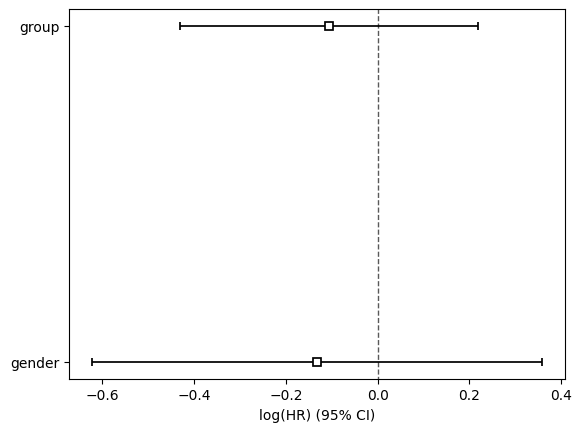

In [23]:
coxph.plot()

In [25]:
# 해당 데이터가 가정을 잘 만족하는지 확인할 수 있다. 
coxph.check_assumptions(data)

Proportional hazard assumption looks okay.


[]

## Accelerated Failure Time (AFT) Model

만약 여기에서, 비례위험가정을 만족하지 못한다면, 가장 많이 사용되는 방법이 accelerated failure time (AFT) Model이다.

생존함수가 모수적 연속 분포를 따른다고 가정하며, 두 모집단 (P, Q)에서 파생된 생존함수가 공변량의 함수로 모델링 할 수 있는 acceleration의 계수인 람다와 관련이 있다고 가정하게 된다